In [3]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

print(halophot.__version__)

Populating the interactive namespace from numpy and matplotlib
0.6.6.3


In [4]:
ls ../data/

MAST_2018-12-06T1534/
MAST_2018-12-06T1557/
MAST_2018-12-06T1606/
astrocut_26.0170142608_-15.9374795978_20x20px.zip
tess-s0001-2-3_340.666848_-46.884558_100x50_astrocut.fits
tess-s0001-2-3_340.666848_-46.884558_200x50_astrocut.fits
tess-s0001-2-3_340.666848_-46.884558_50x50_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_20x20_astrocut.fits
tess2018263035959-s0003-0000000419015728-0123-s_lc.fits
tess2018263035959-s0003-0000000419015728-0123-s_tp.fits


In [28]:
fname = '../data/tess-s0003-1-2_26.0170142608_-15.9374795978_25x35_astrocut.fits'

In [29]:
tpf = lightkurve.open(fname)

In [30]:
bg = tpf.get_bkg_lightcurve()

In [31]:
np.nanmax(tpf.flux)

108081.75

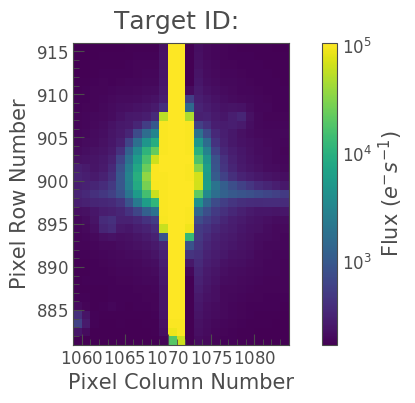

In [32]:
tpf.plot(frame=1,scale='log')
plt.savefig('brightest.png')

In [34]:
help(tpf.interact)

Help on method interact in module lightkurve.targetpixelfile:

interact(notebook_url='localhost:8888', max_cadences=30000, aperture_mask='pipeline', exported_filename=None) method of lightkurve.targetpixelfile.TessTargetPixelFile instance
    Display an interactive Jupyter Notebook widget to inspect the pixel data.
    
    The widget will show both the lightcurve and pixel data.  By default,
    the lightcurve shown is obtained by calling the `to_lightcurve()` method,
    unless the user supplies a custom `LightCurve` object.
    This feature requires an optional dependency, bokeh (v0.12.15 or later).
    This dependency can be installed using e.g. `conda install bokeh`.
    
    At this time, this feature only works inside an active Jupyter
    Notebook, and tends to be too slow when more than ~30,000 cadences
    are contained in the TPF (e.g. short cadence data).
    
    Parameters
    ----------
    notebook_url: str
        Location of the Jupyter notebook page (default: "localh

In [33]:
tpf.interact()

In [145]:
nmax = 15
nmin = 5
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')
xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))
rr = np.sqrt((xx-newmask.shape[0]/2)**2 + (yy-newmask.shape[1]/2)**2)

newmask[(rr>nmax).T] = False
newmask[(rr<nmin).T] = False
newmask[(np.abs(xx-newmask.shape[0]/2+5)<6.).T] = True
newmask[(np.abs(yy-newmask.shape[1]/2-1)<5).T] = False

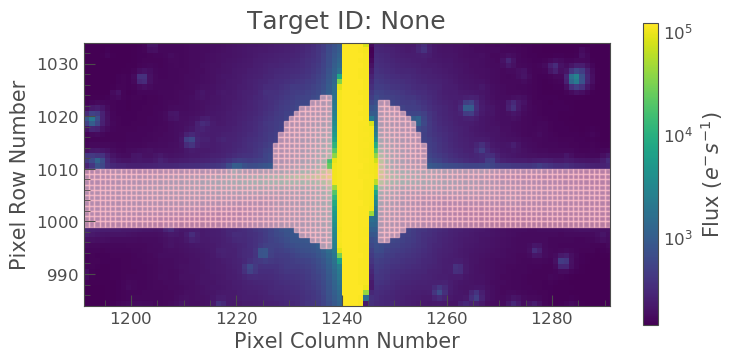

In [146]:
tpf.plot(frame=1,aperture_mask=newmask,scale='log')
plt.savefig('special_aperture.png')

In [9]:
tpf.interact()

In [147]:
lc = tpf.to_lightcurve(aperture_mask=newmask)
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


(0.9, 1.1)

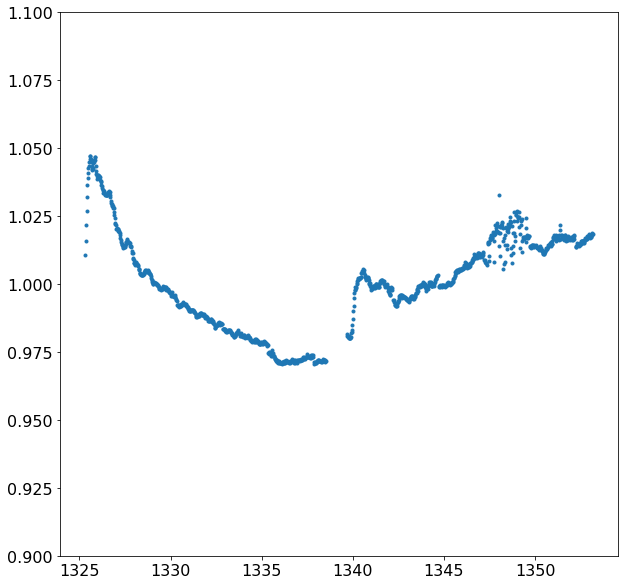

In [148]:
plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.')
plt.ylim(0.9,1.1)

## Now to do Halophot


In [149]:
tpf = halo_tpf(fname)

In [150]:
%%time
weightmap, corr_lc = tpf.halo(order=1,mask=newmask,thresh=0.8);

Taking cadences from beginning to end
1 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 8.31 s, sys: 592 ms, total: 8.9 s
Wall time: 2.38 s


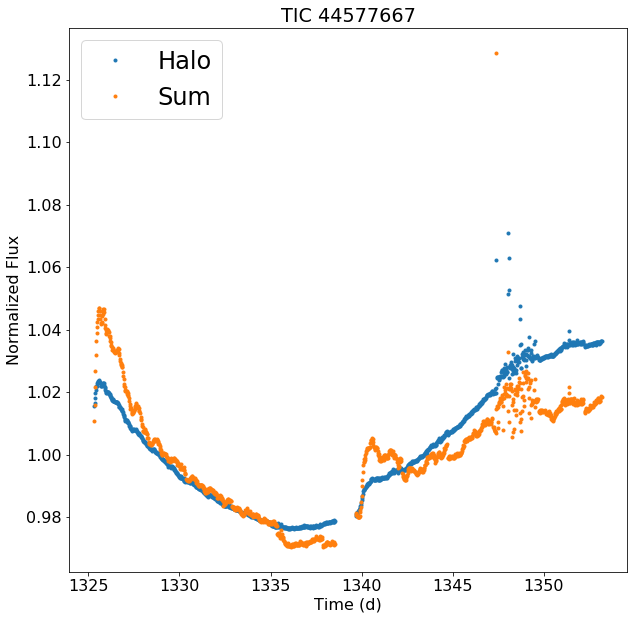

In [151]:
plt.plot(corr_lc.time,corr_lc.flux/np.nanmedian(corr_lc.flux),'.',label='Halo')
plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.ylim(0.98,1.05)
plt.legend(fontsize=24)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title('TIC 44577667')
plt.savefig('halotest.png')

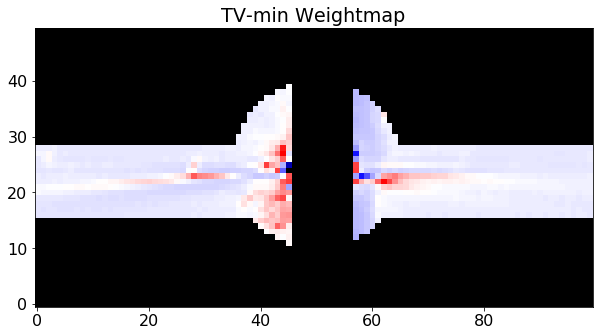

In [128]:
cmap = mpl.cm.seismic
norm = np.size(weightmap)
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
# plt.colorbar()
plt.title('TV-min Weightmap')
plt.savefig('tess_weightmap.png')

In [111]:
print tpf

KeplerTargetPixelFile Object (ID: None)


In [78]:
from astropy.io import fits

In [13]:
f = fits.PrimaryHDU(weightmap)

In [75]:
# f.write_image('tess_weightmap.fits')

### Now let's try and correct it with k2sc

In [78]:
import k2sc
from k2sc import standalone

corr_lc.__class__ = standalone.k2sc_lc
corr_lc.keplerid = corr_lc.targetid

In [79]:
corr_lc.k2sc()

Using default splits [2344] for campaign 5
Starting initial outlier detection
  Flagged 1304 ( 0.0%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    4.65 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
('  DE iteration %3i -ln(L) %4.1f', 0, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 1, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 2, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 3, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 4, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 5, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 6, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 7, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 8, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 9, -4786.780127160795)
('  DE iteration %3i -ln(L) %4.1f', 10, -4786.780127160795)
('  DE iteration %3i -ln(L) %

ValueError: operands could not be broadcast together with shapes (19170,) (19168,) 

In [ ]:
plt.plot(corr_lc.time,corr_lc.flux,'.',label="Uncorrected")
plt.plot(corr_lc.time,corr_lc.corr_flux,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('Aldebaran',y=1.01)